# MATCH

This notebook provides wrapper functions for calling the [MATCH algorithm](https://www.eecs.qmul.ac.uk/~simond/match/).  Running this algorithm requires installing some other software, which is described below.  This notebook implements the `offline_processing()` and `online_processing()` functions, which will be imported and run in `02_RunExperiment.ipynb`.

Here is a summary of the MATCH approach:
- Offline processing: The orchestra and full mix recordings are aligned with standard DTW using chroma features.
- Online processing: The solo piano and full mix recordings are aligned with the MATCH algorithm, and the predicted alignment is then used to infer the corresponding alignment between the piano and orchestra recordings.

## Offline Processing

The offline processing is the same as in the simple offline DTW system.  In the offline processing stage, three things are computed and stored in the `cache/` folder:
- chroma features for the orchestra recording
- chroma features for the full mix recording
- predicted DTW alignment between the orchestra and full mix recordings



In [1]:
import numpy as np
import pandas as pd
import import_ipynb
import System_OfflineDTW
import system_utils
import align_tools
import sonify_tools
import os
import os.path
import subprocess
import librosa as lb
import vamp

importing Jupyter notebook from System_OfflineDTW.ipynb
importing Jupyter notebook from align_tools.ipynb
importing Jupyter notebook from system_utils.ipynb
importing Jupyter notebook from sonify_tools.ipynb
importing Jupyter notebook from tsm_tools.ipynb


In [2]:
def offline_processing(scenario_dir, cache_dir, hop_length, steps, weights):
    '''
    Carries out the same offline processing steps as the simple offline DTW system.
    
    Inputs
    scenario_dir: The scenario directory to process
    cache_dir: The location of the cache directory
    hop_length: The hop length in samples used when computing chroma features
    steps: an L x 2 array specifying the allowable DTW transitions
    weights: a length L array specifying the DTW transition weights
    
    This function will store the computed chroma features and estimated alignment in the cache folder.
    '''
    System_OfflineDTW.offline_processing(scenario_dir, cache_dir, hop_length, steps, weights)
    
    return

In [3]:
def verify_cache_dir(indir):
    '''
    Verifies that the specified cache directory has the required files.
    
    Inputs
    indir: The cache directory to verify
    '''
    assert os.path.exists(f'{indir}/o_chroma.npy'), f'missing {indir}/o_chroma.npy'
    assert os.path.exists(f'{indir}/po_chroma.npy'), f'missing {indir}/po_chroma.npy'
    assert os.path.exists(f'{indir}/o_po_align.npy'), f'missing {indir}/o_po_align.npy'

## Online Processing

In the online processing stage, we do two things:
1. compute an online alignment between the piano and full mix recordings using MATCH,
2. use the predicted alignment to infer the alignment between the piano and orchestra recordings

Note that step 1 is completed before we begin step 2.  This implementation is thus not a valid online system, but its performance nonetheless can tell us how well an online system would perform.

### Software Installation

Using the MATCH algorithm requires a few pieces of software to be installed:
- [Sonic Annotator](https://vamp-plugins.org/sonic-annotator/), a program for command-line processing of audio files
- [the MATCH Vamp plugin](https://code.soundsoftware.ac.uk/projects/match-vamp/), an implementation of the MATCH algorithm which can be used in tandem with Sonic Annotator
- the SoX command line audio utility tool

Below, we will assume that the `sonic-annotator` and `sox` binaries can be called from command line, and that the MATCH Vamp plugin has been installed.  See [here](https://vamp-plugins.org/download.html#install) for instructions on how to install Vamp plugins.

### Wrapper Implementation

In [4]:
def parse_match_outfile(infile):
    '''
    Parses the MATCH csv output file specifying the estimated alignment.
    
    Inputs
    infile: filepath to the MATCH csv output file
    
    Returns a 2xN array indicating the estimated alignment in seconds.
    '''
    d = pd.read_csv(infile, header=None)
    return np.vstack((d.loc[:,1], d.loc[:,2]))

In [5]:
def online_processing(scenario_dir, out_dir, cache_dir, hop_sec, oracle = False):
    '''
    Carries out `online' processing using the MATCH algorithm.
    
    Inputs
    scenario_dir: The scenario directory to process
    out_dir: The directory to put results, intermediate files, and logging info
    cache_dir: The cache directory
    hop_sec: The hop size in sec used in the offline DTW stage
    oracle: boolean specifying if oracle information for query ending time should be used

    This function will compute and save the predicted alignment in the output directory in a file hyp.npy
    '''
    
    # verify & setup
    system_utils.verify_scenario_dir(scenario_dir)
    verify_cache_dir(cache_dir)
    assert not os.path.exists(out_dir), f'Output directory {out_dir} already exists.'
    os.makedirs(out_dir)
           
    # determine the start time of the query in the orchestra recording (ground truth)
    orch_start_sec, orch_end_sec = system_utils.get_orchestra_query_boundaries(scenario_dir)
    
    # infer the start time of the query in the full mix recording (estimated)
    wp_BC_frm = np.flipud(np.load(f'{cache_dir}/o_po_align.npy'))
    wp_BC_frm = np.hstack((np.array([0,0]).reshape((2,-1)), wp_BC_frm)) # prepend (0,0) to handle edge cases properly
    wp_BC_sec = wp_BC_frm * hop_sec
    fullmix_start_sec = np.interp(orch_start_sec, wp_BC_sec[1,:], wp_BC_sec[0,:])    
    
    # create audio recording of full mix containing the region of interest
    fullmix_orig_filepath = f'{scenario_dir}/po.wav'
    fullmix_mod_filepath = f'{out_dir}/po_mod.wav'
    if oracle:
        # use both start and end locations
        fullmix_end_sec = np.interp(orch_end_sec, wp_BC_sec[1,:], wp_BC_sec[0,:]) # estimate end time of query in full mix
        subprocess.run(['sox', fullmix_orig_filepath, fullmix_mod_filepath, 'rate', '22050', 'channels', '1', 'trim', str(fullmix_start_sec), str(fullmix_end_sec)],
                   check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    else:
        # only use start location (continue until end of recording)
        subprocess.run(['sox', fullmix_orig_filepath, fullmix_mod_filepath, 'rate', '22050', 'channels', '1', 'trim', str(fullmix_start_sec)],
                   check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    
    # run MATCH plugin
    piano_filepath = f'{scenario_dir}/p.wav'
    match_align_filepath = f'{out_dir}/match_p_po.out'
    with open(match_align_filepath, 'w') as f:
        subprocess.run(['sonic-annotator', '-d', 'vamp:match-vamp-plugin:match:b_a', '-m', piano_filepath, fullmix_mod_filepath, '-w', 'csv', '--csv-stdout'],
                       check=True, stdout=f, stderr=subprocess.DEVNULL)
    
    # infer piano-orchestra alignment
    wp_AB_sec = parse_match_outfile(match_align_filepath) # piano-fullmix alignment

    duration = lb.get_duration(filename=piano_filepath)
    transposed = wp_AB_sec.transpose()
    transposed = transposed[transposed[:, 0] < duration].transpose()
    transposed[1,:] = transposed[1,:] + fullmix_start_sec # account for offset

    wp_AC_sec = align_tools.infer_alignment(transposed, wp_BC_sec) 
    np.save(f'{out_dir}/hyp.npy', wp_AC_sec)

    # save debugging info
    np.save(f'{out_dir}/p_po_align.npy', wp_AB_sec)
    
    return

In [6]:
def verify_hyp_dir(indir):
    '''
    Verifies that the specified scenario hypothesis directory has the required files.
    
    Inputs
    indir: The cache directory to verify
    '''
    assert os.path.exists(f'{indir}/hyp.npy'), f'{indir} is missing the required files, please re run the online processing'

# Example

Here is an example of how to call the offline and online processing functions on a scenario directory.

In [25]:
# scenario_dir = 'scenarios/s117'
# out_dir = 'experiments/match/s117'
# cache_dir = 'experiments/match/cache/beeth1_mov1_O1_PO2'
# hop_size = 512
# steps = np.array([1,1,1,2,2,1]).reshape((-1,2))
# weights = np.array([2,3,3], dtype=np.float64)
# # offline_processing(scenario_dir, cache_dir, hop_size, steps, weights)

# # determine the start time of the query in the orchestra recording (ground truth)
# orch_start_sec, orch_end_sec = system_utils.get_orchestra_query_boundaries(scenario_dir)

# # infer the start time of the query in the full mix recording (estimated)
# wp_BC_frm = np.flipud(np.load(f'{cache_dir}/o_po_align.npy'))
# wp_BC_frm = np.hstack((np.array([0,0]).reshape((2,-1)), wp_BC_frm)) # prepend (0,0) to handle edge cases properly
# wp_BC_sec = wp_BC_frm * 0.023219954648526078
# fullmix_start_sec = np.interp(orch_start_sec, wp_BC_sec[1,:], wp_BC_sec[0,:])   

# # run MATCH plugin
# piano_filepath = f'{scenario_dir}/p.wav'
# match_align_filepath = f'{out_dir}/match_p_po.out'
# fullmix_mod_filepath = f'{out_dir}/po_mod.wav'
# with open(match_align_filepath, 'w') as f:
#     subprocess.run(['sonic-annotator', '-q', '-d', 'vamp:match-vamp-plugin:match:b_a', '-m', piano_filepath, fullmix_mod_filepath, '-w', 'csv', '--csv-stdout'],
#                     check=True, stdout=f, stderr=subprocess.DEVNULL) 
# # pdata, prate = lb.load(piano_filepath, mono=True, sr=22050)
# # fdata, frate = lb.load(fullmix_mod_filepath, mono=True, sr=22050)
# # assert prate == frate, 'Piano and full mix sample rates do not match'
# # vamp.list_plugins()
# # vamp.get_outputs_of('match-vamp-plugin:match')
# # vamp_result = vamp.collect(sonify_tools.mix_separate_channels(pdata, fdata, pad=True).transpose(), prate, 'match-vamp-plugin:match', output='b_a', parameters={'smooth': 1, 'usechroma': 1, 'metric': 2, 'noise': 1})
# # wp_AB_sec = np.array([[float(item['timestamp']), float(item['values'][0])] for item in vamp_result['list']]).transpose()

In [27]:
# wp_AB_sec = np.vstack(([i['timestamp'] for i in vamp_result['list']], [i['values'][0] for i in vamp_result['list']]))
# infer piano-orchestra alignment
# wp_AB_sec = parse_match_outfile(match_align_filepath) # piano-fullmix alignment
# # wp_AB_sec[1,:] = wp_AB_sec[1,:] + fullmix_start_sec # account for offset

# # crop alignment to the duration of the piano recording
# duration = lb.get_duration(filename=piano_filepath)
# transposed = wp_AB_sec.transpose()
# transposed = transposed[transposed[:, 0] < duration].transpose()
# transposed[1,:] = transposed[1,:] + fullmix_start_sec # account for offset


# wp_AC_sec = align_tools.infer_alignment(transposed, wp_BC_sec) 
# np.save(f'{out_dir}/hyp.npy', wp_AC_sec)

In [9]:
# print(' '.join(['sonic-annotator', '-d', 'vamp:match-vamp-plugin:match:b_a', '-m', piano_filepath, fullmix_mod_filepath, '-w', 'csv', '--csv-stdout']))

sonic-annotator -d vamp:match-vamp-plugin:match:b_a -m scenarios/s118/p.wav experiments/match/s118/po_mod.wav -w csv --csv-stdout


In [10]:
# pdata, prate = lb.load(piano_filepath, mono=True, sr=22050)
# fdata, frate = lb.load(fullmix_mod_filepath, mono=True, sr=22050)
# assert prate == frate, 'Piano and full mix sample rates do not match'
# # vamp.list_plugins()
# # vamp.get_outputs_of('match-vamp-plugin:match')
# vamp_result = vamp.collect(sonify_tools.mix_separate_channels(pdata, fdata).transpose(), prate, 'match-vamp-plugin:match', output='b_a', parameters={'smooth': 1, 'metric': 2})

(0.0, 110.03700320441276)

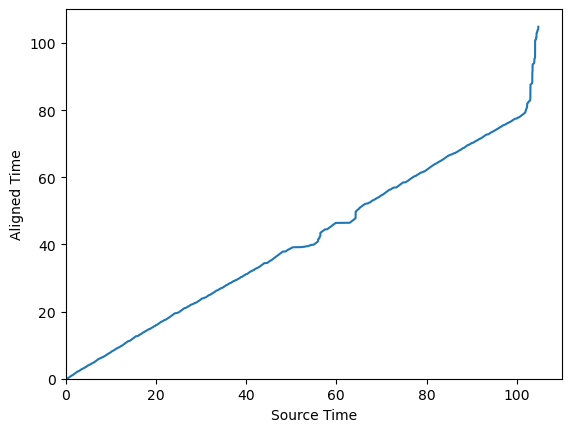

In [21]:
# import matplotlib.pyplot as plt
# alignment = np.array([[float(item['timestamp']), float(item['values'][0])] for item in vamp_result['list']]).transpose()

# plt.plot(alignment[1], alignment[0])
# plt.xlabel('Source Time')
# plt.ylabel('Aligned Time')
# plt.ylim(ymin=0)
# plt.xlim(xmin=0)